In [1]:
import pandas as pd
import geopandas as gpd
import json
# import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab as plt

from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer

import panel as pn
import panel.widgets as pnw

## data file

In [3]:
df = pd.read_csv('../../data/pred_output_full.csv')

In [4]:
df.shape

(401, 176)

In [5]:
df.head(1)

,ags2,bundesland,ags5,kreis,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,...,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-30,2021-08-30
0,1,Schleswig-Holstein,1001,"Flensburg, Stadt",12.7,12.2,12.5,12.3,11.7,11.2,...,8.7,8.8,9.4,9.2,9.1,9.1,8.9,9.104045,8.927351,8.817409


In [6]:
# fix ags5 code to be len=5, add 0 at front
def fix_ags5(x):
    if len(str(x))==4:
        return '0'+str(x)
    else:
        return str(x)

df['ags5'] = df['ags5'].apply(fix_ags5)

In [7]:
df.head(1)

,ags2,bundesland,ags5,kreis,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,...,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-30,2021-08-30
0,1,Schleswig-Holstein,01001,"Flensburg, Stadt",12.7,12.2,12.5,12.3,11.7,11.2,...,8.7,8.8,9.4,9.2,9.1,9.1,8.9,9.104045,8.927351,8.817409


In [37]:
date_cols = merged.columns[4:-9]

In [29]:
year=2021
month=7

In [30]:
if len(str(month))==1:
    month = '0'+str(month)

In [61]:
date_col = merged.filter(like=f'{year}-{month}').columns

In [47]:
index_cols = list(merged.columns[:4]) + list(merged.columns[-9:])

In [63]:
df[['ags5']+list(date_col)]

,ags5,2021-07-30
0,01001,8.927351
1,01002,8.858811
2,01003,8.831366
3,01004,9.267051
4,01051,6.058978
...,...,...
396,16073,6.105627
397,16074,4.469907
398,16075,4.666912
399,16076,4.958671


## geo file

### shapefile

In [8]:
gdf = gpd.read_file('../../georef-germany-kreis/georef-germany-kreis-millesime.shp')

In [9]:
gdf.shape

(401, 9)

In [10]:
gdf.head(1)

,year,lan_code,lan_name,krs_code,krs_name,krs_area_c,krs_type,krs_name_s,geometry
0,2020,08,Baden-WÃ¼rttemberg,08211,"Flensburg, Stadt",DEU,Stadtkreis,Baden-Baden,"MULTIPOLYGON (((8.15840 48.84665, 8.15952 48.8..."


<AxesSubplot:>

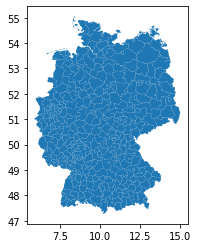

In [11]:
gdf.plot()

### json file

In [11]:
with open('georef-germany-kreis/georef-germany-kreis.json') as response:
    gjs = json.load(response)

In [15]:
merged = pd.merge(df, gdf, left_on='ags5', right_on='krs_code')

In [15]:
# merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
# merged['coords'] = [coords[0] for coords in merged['coords']]

In [16]:
# merged['longitude'] = merged['coords'].str[0]
# merged['latitude'] = merged['coords'].str[1]

In [17]:
# merged = gpd.GeoDataFrame(merged)

In [18]:
# merged_json = json.loads(merged.to_json(), default_handler=str)
# json_data = json.dumps(merged_json)

In [13]:
def get_geodatasource(gdf):    
    """Get getjsondatasource from geopandas object"""
    json_data = json.dumps(json.loads(gdf.to_json()))
    return GeoJSONDataSource(geojson = json_data)

def bokeh_plot_map(gdf, column=None, title=''):
    """Plot bokeh map from GeoJSONDataSource """

    geosource = get_geodatasource(gdf)
    palette = brewer['OrRd'][8]
    palette = palette[::-1]
    vals = gdf[column]
    
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = vals.min(), high = vals.max())
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=20,
                         location=(0,0), orientation='horizontal')

    tools = 'wheel_zoom,pan,reset'
    p = figure(title = title, plot_height=400 , plot_width=850, toolbar_location='right', tools=tools)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    #Add patch renderer to figure
    p.patches('xs','ys', source=geosource, fill_alpha=1, line_width=0.5, line_color='black',  
              fill_color={'field' :column , 'transform': color_mapper})
    
    #Specify figure layout.
    p.add_layout(color_bar, 'below')
    return p

In [3]:
def map_dash(col):
    """Map dashboard"""

    from bokeh.models.widgets import DataTable
    
    map_pane = pn.pane.Bokeh(width=400)
    data_select = pnw.Select(name='dataset',options=list(owid.index))
    year_slider = pnw.IntSlider(start=2007,end=2018,value=2010)
    
    def update_map(event):
        map_pane.object = bokeh_plot_map(merged, col)        
        return
    
    year_slider.param.watch(update_map,'value')
    year_slider.param.trigger('value')
    data_select.param.watch(update_map,'value')
    
    app = pn.Column(pn.Row(data_select,year_slider),map_pane)
    return app

In [4]:
app = map_dash()

NameError: name 'pn' is not defined